# Tarea numero 3 reconocimiento de patrones en imagenes
**nombres**: Lucas Abello, Matias Diaz


# Extraccion de descriptores de las diferentes texturas

In [22]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import MinMaxScaler

def extraccion_textura(gray_img, features, nivel_max=20):
    """
    gray_img: imagen en escala de grises (2D, uint8 o float)
    features: lista de nombres de propiedades ('contrast', ...)
    nivel_max: máximo nivel de gris para la GLCM
    """
    # Asegurarse de que sea uint8
    if gray_img.dtype != np.uint8:
        gray_img = (gray_img * 255).astype(np.uint8)

    # Escalar a 0-nivel_max
    columna = gray_img.reshape(-1, 1)
    resultado = MinMaxScaler(feature_range=(0, nivel_max)).fit_transform(columna).astype(int)
    resultado = resultado.reshape(gray_img.shape)

    # Calcular matriz de co-ocurrencia
    comat = graycomatrix(resultado, distances=[2], angles=[0], levels=nivel_max+1)
    
    S = []
    for ft in features:
        sts = graycoprops(comat, ft).squeeze()
        S.append(float(sts))
    return S

In [ ]:
import os
import cv2

# Ruta a la carpeta BD (Se asume que se extrajo BD.zip)
base_dir = os.getcwd() # Directorio actual
found = os.path.join(base_dir, "BD")  

# Lista de propiedades
caracteristicas = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

data = []
idx = []
labels = []

for d in range(1, 11):
    folder = os.path.join(found, f'textura_{d:02d}')
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith('.jpg')])
    for fname in files:
        path = os.path.join(folder, fname)
        img = cv2.imread(path) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convertir a RGB (cv2 lee en BGR)

        features_img = []

        # Extraer las 6 caracteristicas de cada canal R, G, B  (usando la funcion en el paso anterior)
        for i, canal in enumerate(['R','G','B']):
            channel_img = img[:,:,i]
            features_img.extend(extraccion_textura(channel_img, caracteristicas))

        # extracción de las 6 características de la imagen en escala de grises
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features_img.extend(extraccion_textura(gray_img, caracteristicas))

        data.append(features_img)
        idx.append(fname)
        # agregado de las etiquetas de clase (número de carpeta)
        labels.append(d)


## Creado del dataframe con las caracteristicas extraidas

In [24]:
import pandas as pd

# Crear DataFrame
col_names = []
for canal in ['R','G','B','Gray']:
    for feat in caracteristicas:
        col_names.append(f'{canal}_{feat}')

# añadimos una nueva columna 'clase' al final
col_names_with_class = col_names + ['clase']

# hacemos una verificación de que las etiquetas y los datos coincidan
if len(labels) != len(data):
    raise ValueError(f"Número de etiquetas ({len(labels)}) y filas de datos ({len(data)}) no coinciden")

# combinamos todo
data_with_labels = [row + [lab] for row, lab in zip(data, labels)]

df = pd.DataFrame(data_with_labels, index=idx, columns=col_names_with_class)
print(df.head())
print(f'Total imágenes: {len(df)}, Total características (sin contar clase): {len(col_names)}')


               R_contrast  R_dissimilarity  R_homogeneity  R_energy  \
c264-1_1.jpg     2.208855         1.060726       0.575497  0.130469   
c264-1_10.jpg    2.339823         1.095468       0.565827  0.125859   
c264-1_11.jpg    2.622403         1.162629       0.550326  0.123156   
c264-1_12.jpg    2.658581         1.167097       0.550883  0.124992   
c264-1_13.jpg    2.452371         1.131016       0.555333  0.120433   

               R_correlation     R_ASM  G_contrast  G_dissimilarity  \
c264-1_1.jpg        0.941736  0.017022    2.654435         1.171661   
c264-1_10.jpg       0.945277  0.015840    2.813081         1.205177   
c264-1_11.jpg       0.936537  0.015167    3.084210         1.267339   
c264-1_12.jpg       0.934912  0.015623    3.076565         1.264919   
c264-1_13.jpg       0.934230  0.014504    2.773677         1.206742   

               G_homogeneity  G_energy  ...  B_energy  B_correlation  \
c264-1_1.jpg        0.547693  0.117866  ...  0.116110       0.940726   
c2

# Normalización de los datos

media cero y desviación 1

In [25]:
from sklearn.preprocessing import StandardScaler

# Creamos el escalador
scaler = StandardScaler()

# Escalamos solamente las columnas de características (excluyendo 'clase')
feature_columns = [c for c in df.columns if c != 'clase']
scaled_values = scaler.fit_transform(df[feature_columns])

# creamos el nuevo dataframe con las columnas escaladas y añadimos la columna 'clase' sin escalar
df_normalizado = pd.DataFrame(
    scaled_values,
    index=df.index,         
    columns=feature_columns 
)
# y bueno, concatenamos la columna 'clase' tal cual
df_normalizado['clase'] = df['clase'].values

print(df_normalizado.head())
print("Media por columna:", df_normalizado.mean().round(2).values)
print("Desviación por columna:", df_normalizado.std().round(2).values)


               R_contrast  R_dissimilarity  R_homogeneity  R_energy  \
c264-1_1.jpg    -0.553900        -0.448116       0.288236 -0.412480   
c264-1_10.jpg   -0.498423        -0.372461       0.189359 -0.519981   
c264-1_11.jpg   -0.378723        -0.226209       0.030865 -0.583010   
c264-1_12.jpg   -0.363399        -0.216480       0.036559 -0.540194   
c264-1_13.jpg   -0.450748        -0.295050       0.082062 -0.646506   

               R_correlation     R_ASM  G_contrast  G_dissimilarity  \
c264-1_1.jpg        0.957459 -0.435467   -0.320696        -0.134132   
c264-1_10.jpg       0.984175 -0.511504   -0.247117        -0.056705   
c264-1_11.jpg       0.918233 -0.554814   -0.121368         0.086896   
c264-1_12.jpg       0.905980 -0.525496   -0.124914         0.081307   
c264-1_13.jpg       0.900830 -0.597493   -0.265392        -0.053091   

               G_homogeneity  G_energy  ...  B_energy  B_correlation  \
c264-1_1.jpg       -0.083557 -0.755592  ... -0.762068       0.919865   
c2

# Selección de caracteristicas utilizando SBS

In [26]:
import numpy as np
import pandas as pd
from itertools import combinations
from numpy.matlib import repmat
from numpy.linalg import inv

# funcion índice de Fisher
def fisher_extraction_list(data, cols, clases):
    """
    data   : lista de arrays (uno por clase)
    cols   : número de columnas (features)
    clases : número de clases (int)
    """
    # Caso una sola característica
    if cols == 1:
        D = np.hstack(data)
        Vm = np.mean(D)
        total = len(D)
    else:
        D = np.vstack(data)
        Vm = np.mean(D, axis=0)
        total = D.shape[0]

    p = np.zeros((clases, 1))
    Vk = np.zeros((clases, cols))
    Gn = []

    for i in range(clases):
        Vk[i, :] = np.mean(data[i], axis=0)
        pts = data[i].shape[0]

        if cols == 1:
            Gn.append(data[i] - Vm)
        else:
            Gn.append(data[i] - repmat(Vm, pts, 1))

        p[i] = data[i].shape[0] / total

    # Construcción de matrices inter e intraclase
    Cb = np.zeros((cols, cols))
    Cw = np.zeros((cols, cols))

    for k in range(clases):
        diff = (Vk[k, :] - Vm).reshape(cols, 1)
        Cb += p[k] * (diff @ diff.T)
        MGn = np.array(Gn[k])

        if MGn.shape[0] > 1:
            Cw += p[k] * np.cov(MGn.T)
        else:
            Cw += p[k] * np.zeros((cols, cols))

    # Cálculo índice de Fisher
    J = np.trace(inv(Cw) @ Cb)
    return float(J), Gn, Vk


# aqui ya comenzamos con la parte de SBS

feature_cols = [c for c in df_normalizado.columns if c != 'clase']
cols = len(feature_cols)
col_features = feature_cols
clases = len(df['clase'].unique())

print('columnas (features):', cols)
print('número de clases:', clases)

# Iniciar combinaciones (todas menos una característica)
combs = np.array(list(combinations(np.arange(cols), cols - 1))).reshape(-1, cols - 1)
sel_features = 2
umbral = sel_features
t = cols - 1

# Aqui creamos una funcion auxiliar con la cual construimos sub_data para un conjunto de columnas
def build_sub_data_for_cols(a):
    sub_data = []
    for k in range(1, clases + 1):
        id_class = df['clase'] == k
        tmp = df_normalizado[id_class]
        cols_selected = [col_features[idx] for idx in a]
        arr = tmp[cols_selected].to_numpy()
        if arr.ndim == 1:
            arr = arr.reshape(-1, 1)
        sub_data.append(arr)
    return sub_data


while umbral <= t:
    J = np.zeros(len(combs))

    for i in range(len(combs)):
        a = combs[i]
        sub_data = build_sub_data_for_cols(a)

        # llamamos la función de índice de Fisher
        J[i], Gn, Vk = fisher_extraction_list(sub_data, len(a), clases)
        print(f'  > feature = ({a})  >> J[{i}] = {J[i]:.6f}')

    t -= 1
    best = np.argmax(J)
    vector = combs[best]
    print(f"\nMejor combinación actual (índice {best}): {vector} con J = {J[best]:.6f}\n")

    if len(vector) <= sel_features:
        print('Se alcanzó el número deseado de características.')
        print('Selección final (índices):', vector)
        print('Nombres:', [col_features[idx] for idx in vector])
        break

    combs = np.array(list(combinations(vector, len(vector) - 1))).reshape(-1, len(vector) - 1)

print('SBS (versión original) finalizado.')


columnas (features): 24
número de clases: 10
  > feature = ([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22])  >> J[0] = 50.911171
  > feature = ([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23])  >> J[1] = 47.701204
  > feature = ([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23])  >> J[2] = 50.875104
  > feature = ([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23])  >> J[3] = 51.646266
  > feature = ([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23])  >> J[4] = 51.419533
  > feature = ([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23])  >> J[5] = 51.000530
  > feature = ([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23])  >> J[6] = 51.222719
  > feature = ([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23])  >> J[7] = 50.159577
  > feature = ([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23])  >> 

# Reduccion de muestras con VQ

Aplicando KMeans con k=100 para detectar centroides como muestras representativas...


KMeans terminado. Centroides calculados.
Usando índices seleccionados por SBS: [np.int64(0), np.int64(22)]
Características candidatas para graficar: ['R_contrast', 'Gray_correlation']


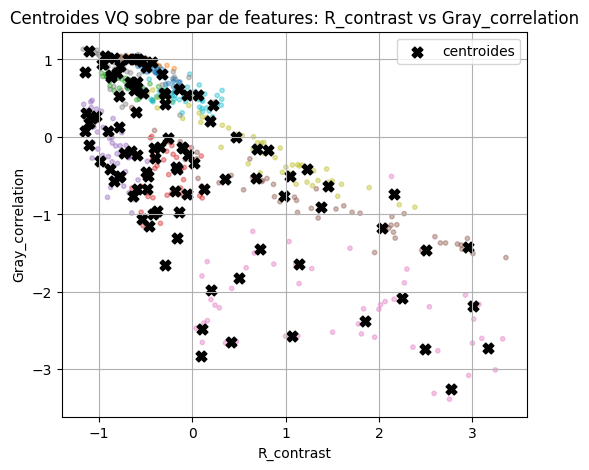

VQ y gráficos completados.


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# muestras objetivo
n_samples_target = 100

# usamos solo las columnas de características excluyendo 'clase'
feature_columns = [c for c in df_normalizado.columns if c != 'clase']
X = df_normalizado[feature_columns].to_numpy()

n_samples = X.shape[0]
if n_samples <= n_samples_target:
    print(f"El dataset ya tiene {n_samples} muestras <= objetivo {n_samples_target}. No se aplica VQ.")
    X_reduced = X
else:
    # usamos kmeans con k = n_samples_target y tomamos los centroides como nuevas muestras
    print(f"Aplicando KMeans con k={n_samples_target} para detectar centroides como muestras representativas...")
    km = KMeans(n_clusters=n_samples_target, random_state=0, n_init=10)
    km.fit(X)
    X_reduced = km.cluster_centers_
    print('KMeans terminado. Centroides calculados.')

# Ahora, queremos graficar los centroides sobre pares de características más representativos.
# Para seleccionar pares representativos: usaremos una medida simple basada en la varianza conjunta
# o usando el índice de Fisher por par. Si el cell de SBS dejó una última vector con índices,
# intentaremos usarlo; si no, seleccionaremos las dos características con mayor varianza.

try:
    last_selected_indices = list(vector)
    print('Usando índices seleccionados por SBS:', last_selected_indices)
except NameError:
    last_selected_indices = None
    print('No se encontró vector de SBS. Seleccionando pares por varianza.')

# mapeamos indices a nombres de columnas si vector existe
if last_selected_indices is not None:
    selected_feature_names = [col_features[i] for i in last_selected_indices]
else:
    # seleccionar las dos características con mayor varianza en df_normalizado
    variances = df_normalizado[feature_columns].var().sort_values(ascending=False)
    selected_feature_names = list(variances.index[:4])  # tomamos top-4 y luego haremos pares

print('Características candidatas para graficar:', selected_feature_names)

# generamos pares de características a graficar (hasta 3 pares)  
from itertools import combinations
pairs = list(combinations(selected_feature_names, 2))[:3]

# plot
for (f1, f2) in pairs:
    i1 = feature_columns.index(f1)
    i2 = feature_columns.index(f2)

    plt.figure(figsize=(6,5))
    sample_idx = np.random.choice(np.arange(X.shape[0]), size=min(1000, X.shape[0]), replace=False)
    plt.scatter(X[sample_idx, i1], X[sample_idx, i2], c=df_normalizado['clase'].values[sample_idx], cmap='tab10', alpha=0.4, s=10)

    # centroides reducidos
    plt.scatter(X_reduced[:, i1], X_reduced[:, i2], c='black', marker='X', s=60, label='centroides')

    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f'Centroides VQ sobre par de features: {f1} vs {f2}')
    plt.legend()
    plt.grid(True)
    plt.show()

print('VQ y gráficos completados.')
